## Import Required Library

In [1]:
import os, shutil
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tqdm import tqdm

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, MobileNetV2, InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import TFSMLayer
from tensorflow.keras.regularizers import l2

import kagglehub

2025-05-22 11:06:07.054706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747911967.255612      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747911967.308334      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Dataset

In [3]:
# Memuat dataset dari kaggle
path = kagglehub.dataset_download("dipoyonoarga/dataset-singkong")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dataset-singkong


In [4]:
# Memindahkan dataset ke writable folder
src = '/kaggle/input/dataset-singkong/Dataset-Singkong'
dst = '/kaggle/working/Dataset-Singkong'

if not os.path.exists(dst):
    shutil.copytree(src, dst)

In [5]:
# Mendefinisikan path ke dataset dan daftar kelas
dataset_path = '/kaggle/working/Dataset-Singkong'
classes = os.listdir(dataset_path)

# Mengecek isi dataset
print(classes)

['Cassava___bacterial_blight', 'Cassava___green_mottle', 'Cassava___brown_streak_disease', 'Cassava___healthy', 'Cassava___mosaic_disease']


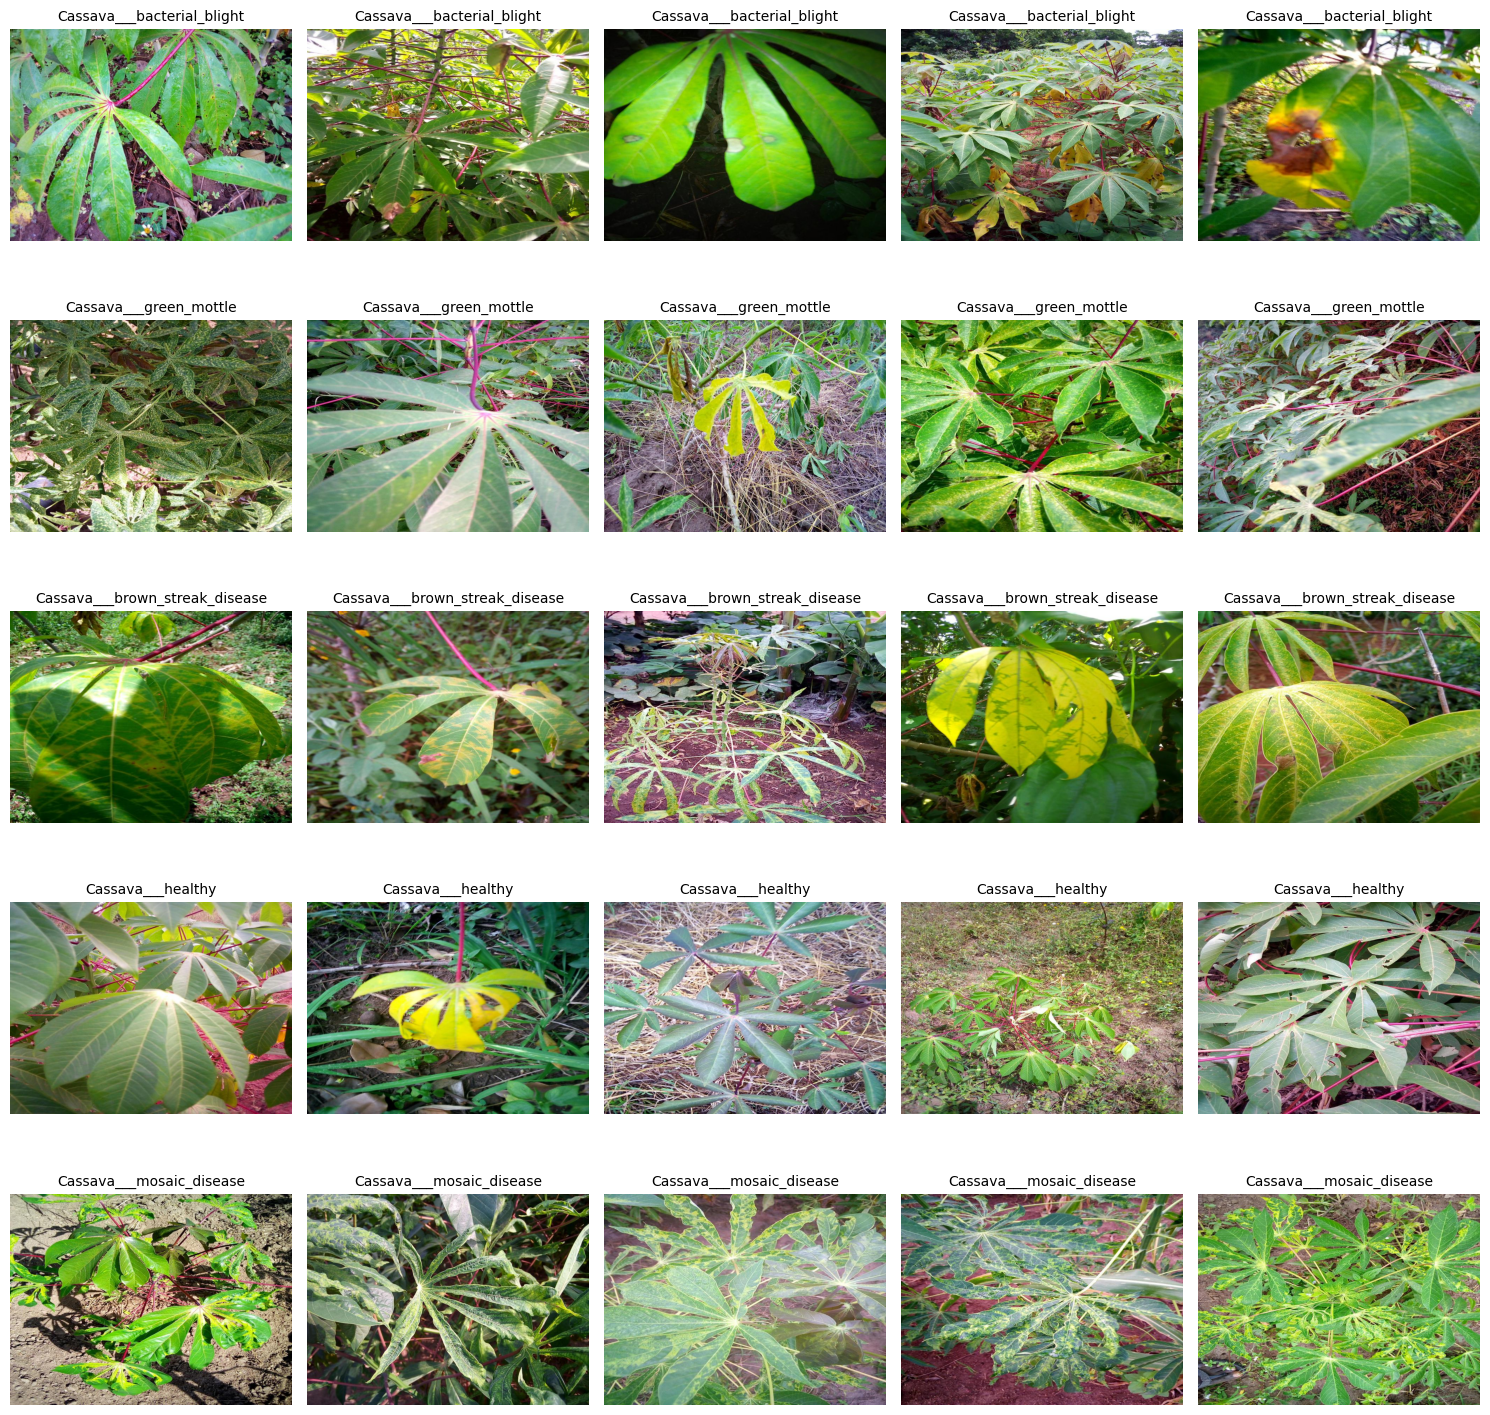

In [6]:
# Setup plot dengan ukuran yang dinamis berdasarkan jumlah kelas
plt.figure(figsize=(15, 3 * len(classes)))

# Loop melalui setiap kelas
for class_index, disease_class in enumerate(classes):
    class_folder_path = os.path.join(dataset_path, disease_class)
    image_files = os.listdir(class_folder_path)[:5]  # Ambil 5 gambar pertama

    # Loop melalui setiap gambar dalam kelas
    for image_index, image_file in enumerate(image_files):
      full_image_path = os.path.join(class_folder_path, image_file)

      # Menyipkan posisi subplot
      subplot_position = class_index * 5 + image_index + 1
      plt.subplot(len(classes), 5, subplot_position)

      # Menampilkan gambar
      plt.imshow(Image.open(full_image_path))
      plt.title(disease_class, fontsize=10)
      plt.axis('off')

plt.tight_layout()
plt.show()

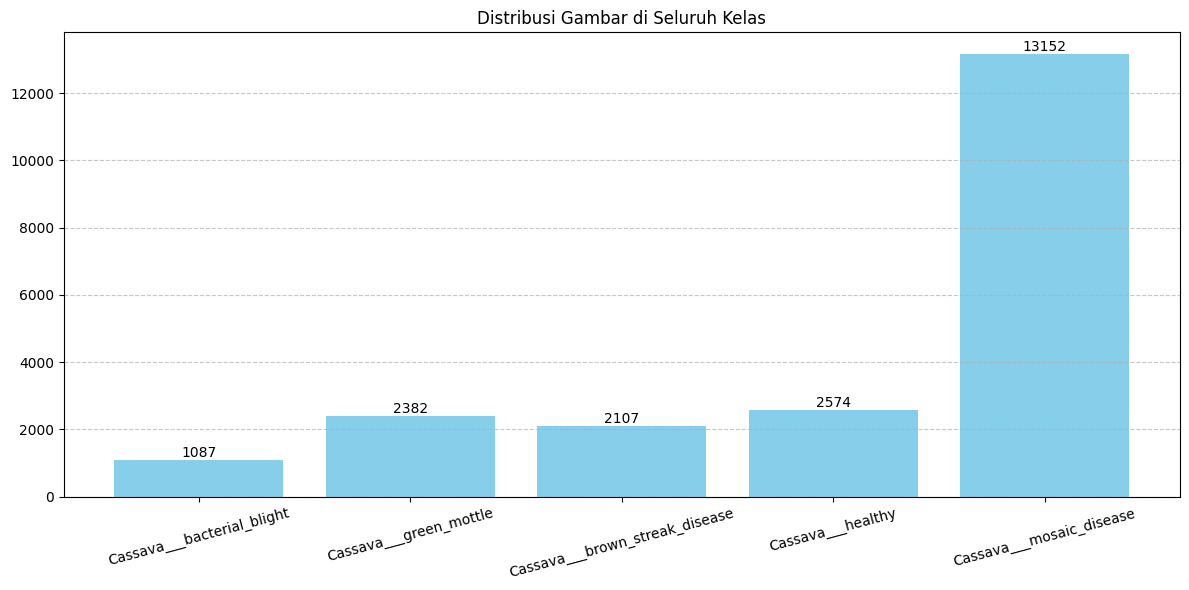

In [7]:
# Hitung jumlah gambar per kelas
imageCount = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar di Seluruh Kelas")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [8]:
# Undersampling, mengurangi jumlah dataset untuk semua kelas
base_folder_path = dataset_path
target_count_per_class = 5000 # Ganti dengan jumlah target yang Anda inginkan per kelas

for class_name in classes:
    folder_path = os.path.join(base_folder_path, class_name)
    if os.path.isdir(folder_path): # Pastikan itu adalah folder
        all_files = os.listdir(folder_path)
        random.shuffle(all_files)

        # Jika jumlah file melebihi target_count_per_class, hapus file berlebih
        if len(all_files) > target_count_per_class:
            files_to_keep = set(all_files[:target_count_per_class])
            files_to_remove = [file for file in all_files if file not in files_to_keep]

            print(f"Mengurangi jumlah file di '{class_name}': Menghapus {len(files_to_remove)} file.")
            for file in files_to_remove:
                os.remove(os.path.join(folder_path, file))
        else:
            print(f"Jumlah file di '{class_name}' ({len(all_files)}) sudah kurang dari atau sama dengan target ({target_count_per_class}). Tidak ada file yang dihapus.")

# Verifikasi setelah pengurangan
print("\nJumlah file per kelas setelah pengurangan:")
imageCount_after = {class_name: len(os.listdir(os.path.join(base_folder_path, class_name))) for class_name in classes if os.path.isdir(os.path.join(base_folder_path, class_name))}
for class_name, count in imageCount_after.items():
    print(f"{class_name}: {count}")

Jumlah file di 'Cassava___bacterial_blight' (1087) sudah kurang dari atau sama dengan target (5000). Tidak ada file yang dihapus.
Jumlah file di 'Cassava___green_mottle' (2382) sudah kurang dari atau sama dengan target (5000). Tidak ada file yang dihapus.
Jumlah file di 'Cassava___brown_streak_disease' (2107) sudah kurang dari atau sama dengan target (5000). Tidak ada file yang dihapus.
Jumlah file di 'Cassava___healthy' (2574) sudah kurang dari atau sama dengan target (5000). Tidak ada file yang dihapus.
Mengurangi jumlah file di 'Cassava___mosaic_disease': Menghapus 8152 file.

Jumlah file per kelas setelah pengurangan:
Cassava___bacterial_blight: 1087
Cassava___green_mottle: 2382
Cassava___brown_streak_disease: 2107
Cassava___healthy: 2574
Cassava___mosaic_disease: 5000


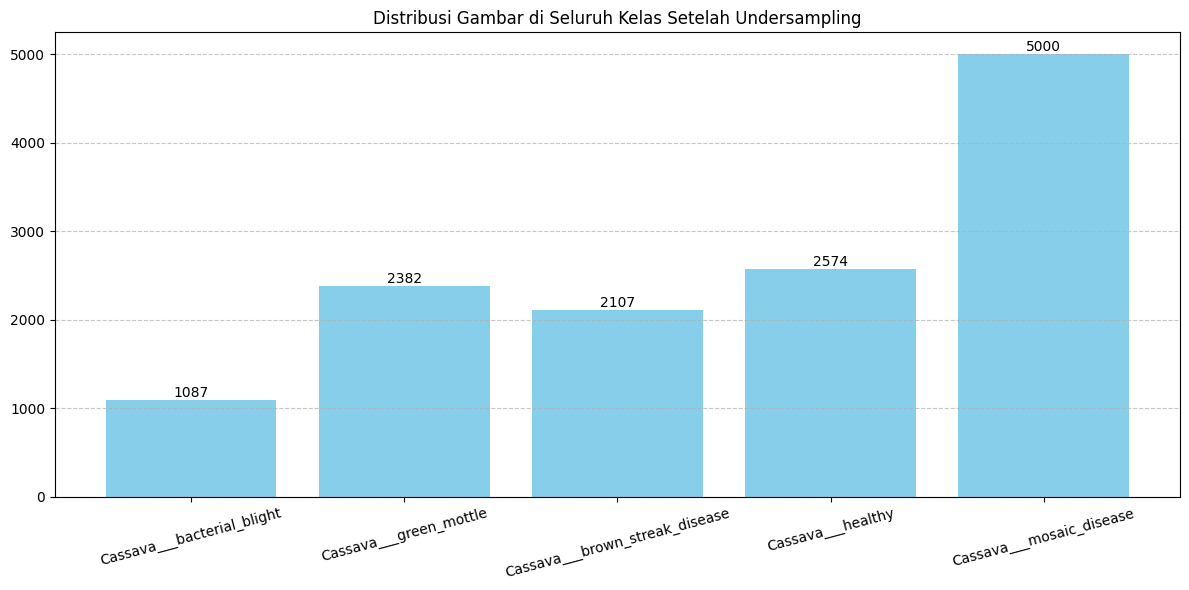

In [9]:
# Hitung jumlah gambar per kelas
imageCount = {class_name: len(os.listdir(os.path.join(dataset_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar di Seluruh Kelas Setelah Undersampling")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Split dataset

# Path asal dataset
source_dir = '/kaggle/working/Dataset-Singkong'

# Path tujuan
output_base_dir = '/kaggle/working/Dataset-Ready'
train_dir = os.path.join(output_base_dir, 'train')
val_dir = os.path.join(output_base_dir, 'val')
test_dir = os.path.join(output_base_dir, 'test')

# Rasio pembagian
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Membuat direktori tujuan
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# Proses pemisahan tiap kelas
for class_name in tqdm(os.listdir(source_dir), desc='Memproses kelas'):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Ambil semua nama file gambar
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_count = int(train_ratio * total)
    val_count = int(val_ratio * total)
    test_count = total - train_count - val_count

    split_counts = {
        'train': images[:train_count],
        'val': images[train_count:train_count + val_count],
        'test': images[train_count + val_count:]
    }

    for split, split_images in split_counts.items():
        split_class_dir = os.path.join(output_base_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_name in split_images:
            src_path = os.path.join(class_path, img_name)
            dst_path = os.path.join(split_class_dir, img_name)
            shutil.copy2(src_path, dst_path)

Memproses kelas: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


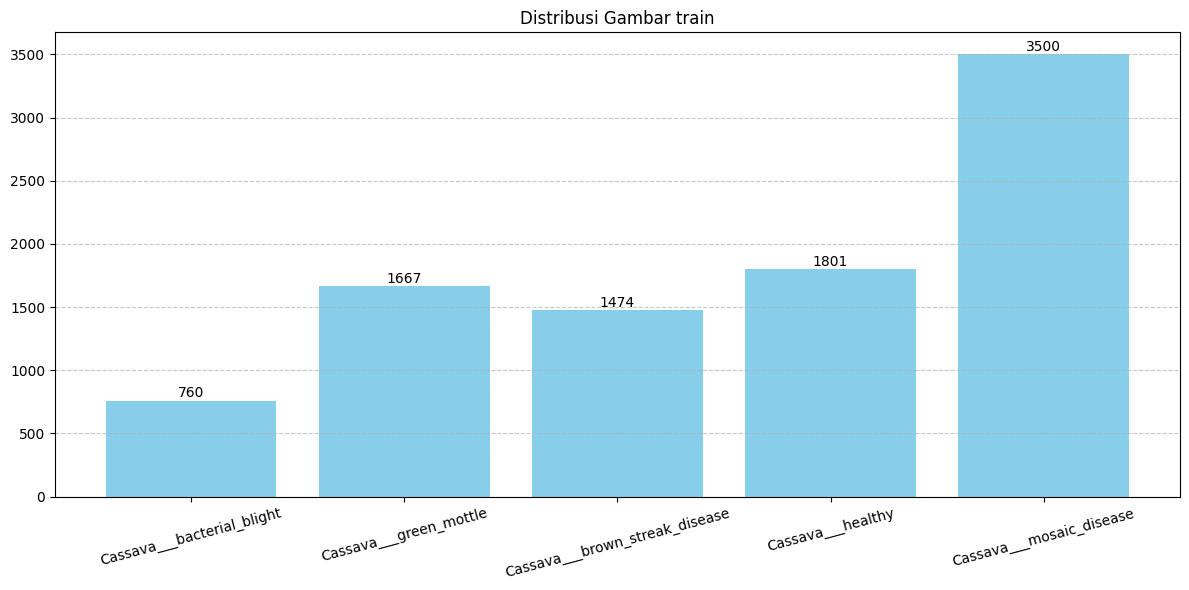

In [11]:
# Hitung jumlah gambar train
train_path = '/kaggle/working/Dataset-Ready/train'
imageCount = {class_name: len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar train")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
!pip install albumentations 

In [13]:
import os
import numpy as np
import cv2
from albumentations import (
    Compose, Resize, HorizontalFlip, VerticalFlip,
    Affine, RandomBrightnessContrast, HueSaturationValue,
    CLAHE, RandomGamma, Blur, GaussNoise, OneOf
)
from albumentations.core.composition import OneOf
from tqdm import tqdm
from datetime import datetime

# === PARAMETER ===
train_dir = '/kaggle/working/Dataset-Ready/train'  # Ganti jika path-nya berbeda
target_count = 5000
img_size = (150, 150)

# === PIPELINE AUGMENTASI ===
transform = Compose([
    Resize(*img_size),
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Affine(translate_percent=0.1, scale=(0.8, 1.2), rotate=(-30, 30), p=0.5),
    OneOf([
        RandomBrightnessContrast(p=0.5),
        HueSaturationValue(p=0.5),
        CLAHE(p=0.5)
    ], p=0.7),
    OneOf([
        Blur(blur_limit=3, p=0.3),
        GaussNoise(p=0.3)
    ], p=0.5),
    RandomGamma(p=0.3)
])

# === LOOP SETIAP KELAS ===
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)
    needed = target_count - current_count

    print(f"\nAugmenting '{class_name}': current = {current_count}, need = {needed}")
    if needed <= 0:
        continue

    i = 0
    while i < needed:
        img_name = np.random.choice(image_files)
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"❌ Failed to read image: {img_path}")
            continue

        # Convert BGR to RGB (albumentations expects RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply augmentation
        augmented = transform(image=img)
        aug_img = augmented['image']

        # Convert back to BGR for saving
        aug_img = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

        # Save with unique name
        timestamp = datetime.now().strftime("%Y%m%d%H%M%S%f")
        save_name = f"aug_{i}_{timestamp}.jpg"
        save_path = os.path.join(class_path, save_name)
        cv2.imwrite(save_path, aug_img)

        i += 1


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()



Augmenting 'Cassava___bacterial_blight': current = 760, need = 4240

Augmenting 'Cassava___green_mottle': current = 1667, need = 3333

Augmenting 'Cassava___brown_streak_disease': current = 1474, need = 3526

Augmenting 'Cassava___healthy': current = 1801, need = 3199

Augmenting 'Cassava___mosaic_disease': current = 3500, need = 1500


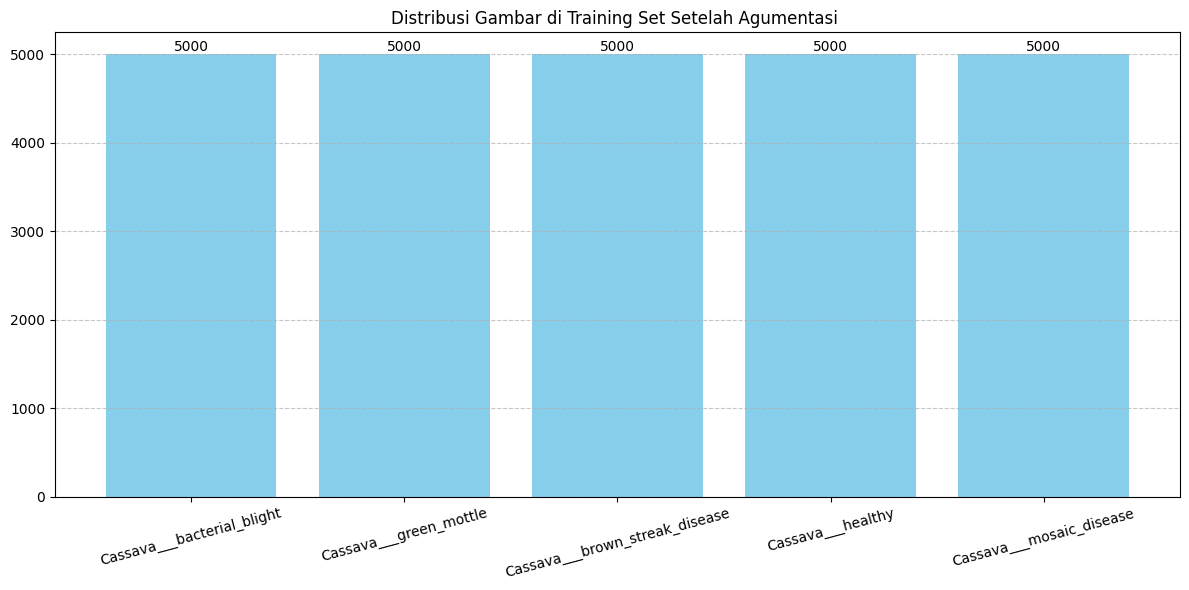

In [14]:
# Hitung jumlah gambar train
train_path = '/kaggle/working/Dataset-Ready/train'
imageCount = {class_name: len(os.listdir(os.path.join(train_path, class_name))) for class_name in classes}
labels = list(imageCount.keys())
counts = list(imageCount.values())

# Membuat plot batang
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, counts, color='skyblue')

# Menambahkan angka di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=10)

# Atur tampilan plot
plt.title("Distribusi Gambar di Training Set Setelah Agumentasi ")
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path dataset
DATASET_PATH = "/kaggle/working/Dataset-Ready"
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
SEED = 42

# Data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load images
train_generator = train_datagen.flow_from_directory(
    directory=f"{DATASET_PATH}/train",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_generator = val_test_datagen.flow_from_directory(
    directory=f"{DATASET_PATH}/val",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

test_generator = val_test_datagen.flow_from_directory(
    directory=f"{DATASET_PATH}/test",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

NUM_CLASSES = train_generator.num_classes

Found 25000 images belonging to 5 classes.
Found 1972 images belonging to 5 classes.
Found 1976 images belonging to 5 classes.


## Modelling

In [16]:
#Improve CNN (acu: 70, val: 59, test: 58)
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

def build_model(input_shape=(150, 150, 3), n_classes=5):
    model = Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),

        layers.Dense(n_classes, activation='softmax')  # 5 kelas cassava
    ])

    model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

    return model

# Inisialisasi model baru
model = build_model()

# Simpan bobot awal
initial_weights = model.get_weights()

# Reset model ke kondisi awal sebelum fit
model.set_weights(initial_weights)

# Callback untuk menghentikan pelatihan ketika akurasi training & validasi mencapai 99%
class AccuracyThresholdCallback(Callback):
    def __init__(self, train_acc=0.95, val_acc=0.90):
        super(AccuracyThresholdCallback, self).__init__()
        self.train_acc = train_acc
        self.val_acc = val_acc

    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if train_accuracy is not None and val_accuracy is not None:
            if train_accuracy >= self.train_acc and val_accuracy >= self.val_acc:
                print(f"\nTraining & validation accuracy telah mencapai lebih dari {self.train_acc * 100}%. Training model dihentikan.")
                self.model.stop_training = True

# Callback untuk menghentikan model jika val_loss tidak membaik
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

I0000 00:00:1747912322.137610      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
# Latih model
history = model.fit(
    train_generator,
    epochs=200,
    batch_size=32,
    validation_data=val_generator,
    verbose=1,
    callbacks=AccuracyThresholdCallback(train_acc=0.95, val_acc=0.90)
)

Epoch 1/200


I0000 00:00:1747912330.144313      90 service.cc:148] XLA service 0x7e8b98002800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747912330.145149      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747912330.801914      90 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/782 ━━━━━━━━━━━━━━━━━━━━ 2:41:45 12s/step - accuracy: 0.1875 - loss: 3.9886

I0000 00:00:1747912336.585752      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 172s 204ms/step - accuracy: 0.2768 - loss: 3.2951 - val_accuracy: 0.3651 - val_loss: 2.7789
Epoch 2/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 150s 192ms/step - accuracy: 0.3603 - loss: 2.7232 - val_accuracy: 0.3666 - val_loss: 2.4771
Epoch 3/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 193ms/step - accuracy: 0.3885 - loss: 2.3528 - val_accuracy: 0.4082 - val_loss: 2.1365
Epoch 4/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 193ms/step - accuracy: 0.4098 - loss: 2.0470 - val_accuracy: 0.3986 - val_loss: 1.9132
Epoch 5/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 193ms/step - accuracy: 0.4432 - loss: 1.8000 - val_accuracy: 0.2211 - val_loss: 2.2464
Epoch 6/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 152s 194ms/step - accuracy: 0.4494 - loss: 1.6397 - val_accuracy: 0.4310 - val_loss: 1.6403
Epoch 7/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 153s 195ms/step - accuracy: 0.4697 - loss: 1.5107 - val_accuracy: 0.3164 - val_loss: 1.8801
Epoch 8/200
782/782 ━━━━━━━━━━━━━━━━━━━━ 151s 193ms/step - accuracy: 0.4839 - los

In [19]:
steps = test_generator.samples // 32  # Ganti 32 dengan nilai batch size yang sebenarnya
test_loss, test_accuracy = model.evaluate(test_generator, steps=steps, verbose=1)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.5240 - loss: 1.5211
Test Accuracy: 65.11%


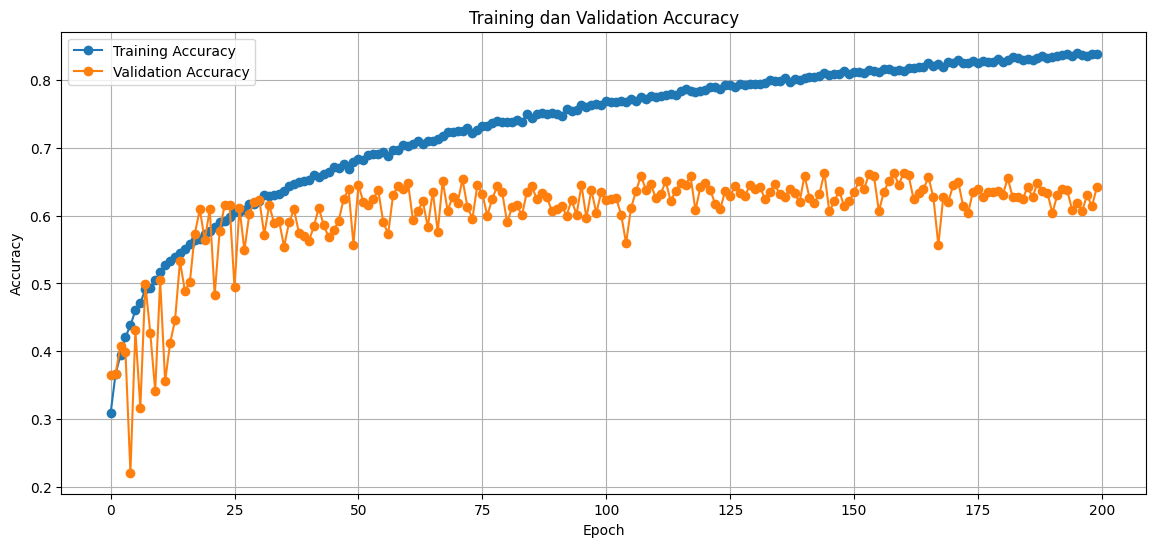

In [20]:
# Mengambil data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot akurasi dan loss
plt.figure(figsize=(14, 6))

plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training dan Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

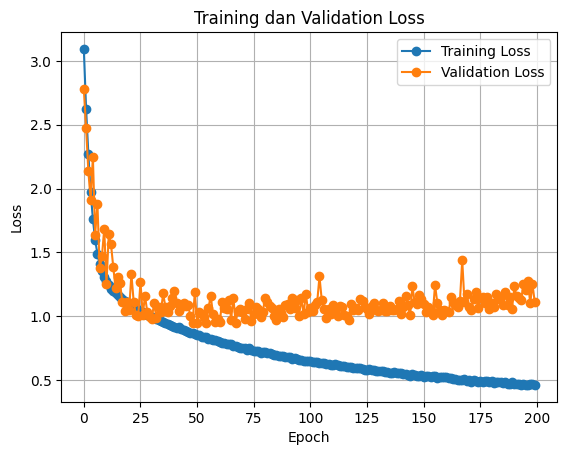

In [21]:
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training dan Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()